In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spat
import scipy.signal as sig
import scipy.ndimage as sim
import matplotlib.animation

We import the straightened points

In [2]:
ptstraight=np.load("./data/straightened/allstatesfromSegNetv2.npy",allow_pickle=True)
ptsnotstraight=np.load("./data/peaks/peaks-184FromSegnetv2.npy",allow_pickle=True)
ground=np.load("./data/ground.npy")

In [3]:
pot=np.empty((291,191))
tree=spat.cKDTree(ground[:,:2])
for i in range(291):
    for j in range(191):
        d,x=tree.query([i,j-95],k=1)
        pot[i,j]=d/100
        continue
        d=d[1]
        if d<25:
            pot[i,j]=d*2.5/100
        else:
            pot[i,j]=d**2/1000
pot=sim.gaussian_filter(pot,6)

We only compute the potential energy this time.

In [4]:
def potenergy(pts):
    return np.sum(sim.map_coordinates(pot,[pts[:,0],pts[:,1]],order=1,mode="nearest"))/len(pts)

Potential Energy 0.04413434989945241


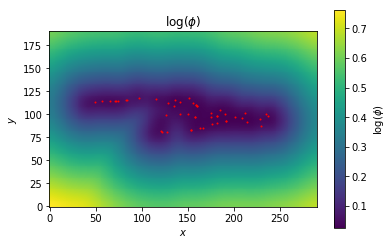

In [8]:
t=np.random.randint(0,len(ptsnotstraight))
plt.imshow(np.log(pot+1).T,origin="below")
plt.title(r"log($\phi$)")
plt.colorbar(label=r"log($\phi$)")
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.scatter(*ptstraight[t].T,c="r",s=1)
print("Potential Energy",potenergy(ptstraight[t]))

We filter out high energy frames

In [363]:
potenergies=[]
outinds=[]
highenergyinds=[]
goodframes=[]
potthres=0.05#The threshold
for i in range(3002):
    if len(ptstraight[i])==0:
        outinds.append(i)
        potenergies.append(0)
        continue
    penergy=potenergy(ptstraight[i])
    if penergy>potthres:
        highenergyinds.append(i)
    else:
        goodframes.append(np.concatenate((ptstraight[i],ptsnotstraight[i][:,2][:,None]),axis=1))
    potenergies.append(penergy)
print("Total frames:",len(ptstraight)," Well-Straightened Frames:",len(goodframes)
      ," High Energy Frames at threshold",potthres,":",len(highenergyinds),"No peaks:",len(outinds))

Total frames: 3002  Well-Straightened Frames: 2708  High Energy Frames at threshold 0.05 : 259 No peaks: 35


We see that the worm is not well straightened when it curves.

<IPython.core.display.Javascript object>


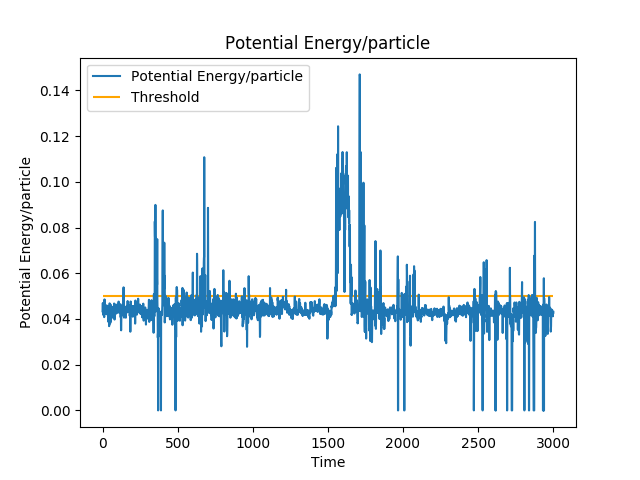

In [364]:
plt.plot(potenergies,label="Potential Energy/particle")
plt.hlines(potthres,0,len(ptstraight),color="orange",label="Threshold")
plt.xlabel("Time")
plt.ylabel("Potential Energy/particle")
plt.title("Potential Energy/particle")
plt.legend()

For example:

<IPython.core.display.Javascript object>


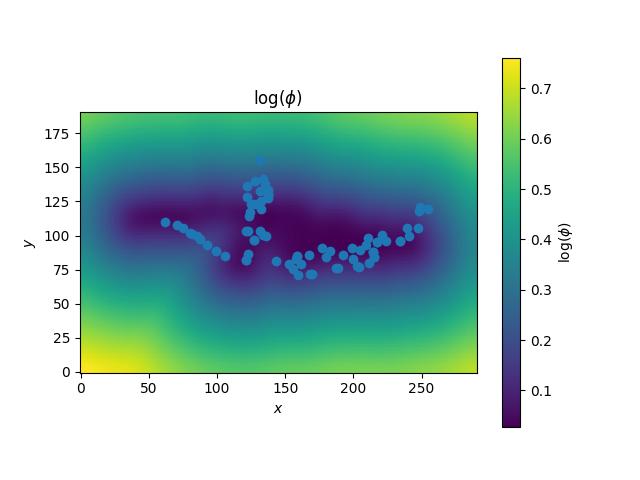

In [379]:
t=np.random.randint(0,len(highenergyinds))
plt.imshow(np.log(pot+1).T,origin="below")
plt.title(r"log($\phi$)")
plt.colorbar(label=r"log($\phi$)")
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.scatter(*ptstraight[highenergyinds[t]].T)

Number of surviving frames is:

In [380]:
len(goodframes)

2708

We can make a video:

In [381]:
vidstates=[]
errs=[]
indvidtoori={}
count=0
for i,st in enumerate(goodframes):
    if len(st)==0 or st[0] is "div":
        errs.append(st)
    else:
        vidstates.append(st)
        indvidtoori[count]=i
        count+=1

ims=[]
for i,vidst in enumerate(vidstates):
    im=np.zeros((290,190))
    for pt in vidst:
        try:
            im[int(pt[0]),int(pt[1])]+=1
        except:
            pass
    ims.append(sim.gaussian_filter(im,2))
print(len(vidstates),"fully straightened frames")

2708 fully straightened frames


<IPython.core.display.Javascript object>


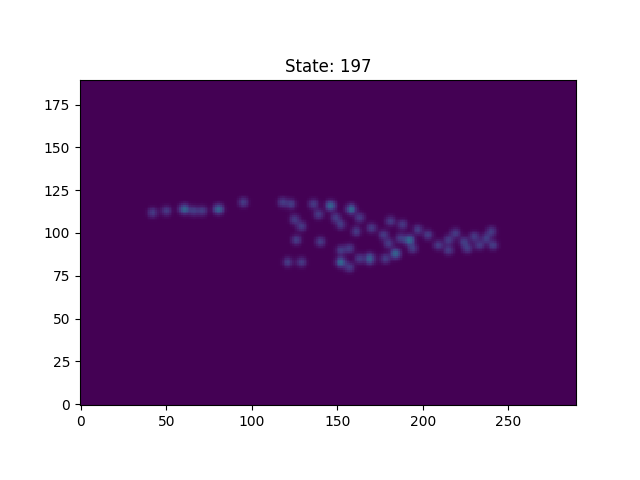

In [382]:
%matplotlib notebook
fig = plt.figure()
ax = fig.gca()

image = plt.imshow(ims[0].T,animated=True,origin="below")

def animate(frame_index):
    image.set_data(np.log(ims[frame_index]+1).T)
    ax.set_title("State: "+str(frame_index))
    return image,

ani = matplotlib.animation.FuncAnimation(fig,animate, interval=80, frames=len(ims), blit=True)
#ani.save('./Figure:Video/Straightened-from-image.mp4', writer="ffmpeg")

Save the good ones

In [383]:
#np.save("./data/peaks/cleaned-test.npy",goodframes)